In [1]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 2D problem such as the Darcy Flow discussed in Section 5.2 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
from utilities3 import *

torch.manual_seed(0)
np.random.seed(0)

#Complex multiplication
def compl_mul2d(a, b):
    # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
    op = partial(torch.einsum, "bixy,ioxy->boxy")
    return torch.stack([
        op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
        op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    ], dim=-1)


################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 2))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 2))

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.rfft(x, 2, normalized=True, onesided=True)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.in_channels,  x.size(-2), x.size(-1)//2 + 1, 2, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.irfft(out_ft, 2, normalized=True, onesided=True, signal_sizes=( x.size(-2), x.size(-1)))
        return x

class SimpleBlock2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(SimpleBlock2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm2d(self.width)
        self.bn1 = torch.nn.BatchNorm2d(self.width)
        self.bn2 = torch.nn.BatchNorm2d(self.width)
        self.bn3 = torch.nn.BatchNorm2d(self.width)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2]

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn0(x1 + x2)
        x = F.relu(x)
        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn1(x1 + x2)
        x = F.relu(x)
        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn2(x1 + x2)
        x = F.relu(x)
        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn3(x1 + x2)


        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Net2d(nn.Module):
    def __init__(self, modes, width):
        super(Net2d, self).__init__()

        """
        A wrapper function
        """

        self.conv1 = SimpleBlock2d(modes, modes,  width)


    def forward(self, x):
        x = self.conv1(x)
        return x.squeeze()


    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c

################################################################
# configs
################################################################
TRAIN_PATH = 'data/piececonst_r421_N1024_smooth1.mat'
TEST_PATH = 'data/piececonst_r421_N1024_smooth2.mat'

ntrain = 1000
ntest = 100

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

modes = 12
width = 32

r = 5
h = int(((421 - 1)/r) + 1)
s = h

################################################################
# load data and data normalization
################################################################
reader = MatReader(TRAIN_PATH)
x_train = reader.read_field('coeff')[:ntrain,::r,::r][:,:s,:s]
y_train = reader.read_field('sol')[:ntrain,::r,::r][:,:s,:s]

reader.load_file(TEST_PATH)
x_test = reader.read_field('coeff')[:ntest,::r,::r][:,:s,:s]
y_test = reader.read_field('sol')[:ntest,::r,::r][:,:s,:s]

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

grids = []
grids.append(np.linspace(0, 1, s))
grids.append(np.linspace(0, 1, s))
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid = grid.reshape(1,s,s,2)
grid = torch.tensor(grid, dtype=torch.float)
x_train = torch.cat([x_train.reshape(ntrain,s,s,1), grid.repeat(ntrain,1,1,1)], dim=3)
x_test = torch.cat([x_test.reshape(ntest,s,s,1), grid.repeat(ntest,1,1,1)], dim=3)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

################################################################
# training and evaluation
################################################################
model = Net2d(modes, width).cuda()
print(model.count_params())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
y_normalizer.cuda()
for ep in range(10):
    model.train()
    t1 = default_timer()
    train_mse = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        # loss = F.mse_loss(model(x).view(-1), y.view(-1), reduction='mean')
        out = model(x)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)
        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()


        optimizer.step()
        train_mse += loss.item()

    scheduler.step()

    model.eval()
    abs_err = 0.0
    rel_err = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)
            out = y_normalizer.decode(model(x))

            rel_err += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

    train_mse/= ntrain
    abs_err /= ntest
    rel_err /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, rel_err)


2368257


C:\Users\Saad.LAKES\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:590.)
C:\Users\Saad.LAKES\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:602.)


0 7.075728900000001 0.08258861941099167 0.054312524795532224
1 2.6743314 0.042341441690921786 0.0326724523305893
2 2.675319200000004 0.036716188311576844 0.03264927089214325
3 2.6695689000000016 0.03313104504346848 0.050001042485237124
4 2.6728333000000006 0.03057122787833214 0.03340366959571838
5 2.673022099999997 0.028603797048330305 0.027422003149986267
6 2.684135000000005 0.02799464440345764 0.024937905073165893
7 2.67256789999999 0.028408601373434067 0.027143085598945616
8 2.6806286999999998 0.02532310011982918 0.029898411631584167
9 2.6787511999999936 0.030792053282260895 0.02910302996635437


In [40]:
pred = torch.zeros(y_test.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x)
        out = y_normalizer.decode(model(x))
        pred[index] = out
        index = index + 1

In [41]:
pred.shape

torch.Size([100, 85, 85])

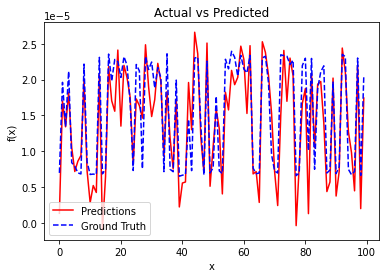

In [44]:
plt.plot(pred[:,0,0],'r-',label='Predictions')
plt.plot(y_test[:,0,0],'b--',label='Ground Truth')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Actual vs Predicted')
plt.legend(loc='lower left')
# plt.savefig('Output_burgers')
plt.show()

In [48]:
pred[:,0,1]

tensor([6.1371e-06, 8.1784e-06, 2.1651e-05, 1.7627e-05, 6.5006e-06, 6.8759e-06,
        5.7718e-06, 6.3189e-06, 1.3160e-05, 6.7827e-06, 1.7836e-06, 2.6392e-06,
        2.8674e-06, 1.7689e-05, 1.9713e-06, 5.5981e-06, 8.8047e-06, 5.6578e-06,
        1.0044e-05, 1.3489e-05, 1.4566e-05, 8.1461e-06, 1.1778e-05, 1.0592e-05,
        4.4134e-06, 1.1913e-05, 1.5729e-05, 1.0385e-05, 1.1802e-05, 1.0963e-05,
        1.0497e-05, 7.9642e-06, 1.1453e-05, 2.1285e-05, 8.1420e-06, 1.8800e-05,
        1.0511e-05, 4.4280e-06, 2.0820e-05, 4.4702e-06, 5.5907e-06, 4.2113e-06,
        1.3474e-05, 7.7877e-06, 1.6781e-05, 1.2715e-05, 1.0811e-05, 3.6994e-06,
        2.0667e-05, 5.5138e-06, 7.6591e-06, 1.5677e-05, 6.0764e-06, 2.5199e-06,
        1.2627e-05, 4.5578e-06, 1.2683e-05, 1.9122e-05, 7.2684e-06, 1.2395e-05,
        1.0804e-05, 1.2290e-05, 1.1217e-05, 1.8344e-06, 4.5537e-06, 4.8423e-06,
        1.4148e-05, 2.0395e-05, 1.1971e-05, 6.2320e-06, 1.3662e-06, 5.0070e-06,
        9.6794e-06, 1.1976e-05, 1.5884e-